---
title: Classifying Palmer's Penguins
author: Will Lavey
date: '2025-02-28'
image: "penguins_cover_photo.jpeg"
description: "The first blog post for CS451, classifying Palmer's Penguins"
format: html
---

# A Classification Exercise of Palmer's Penguins

## Abstract

The aim of this blog post is to explore the relationships between predictor variables and the species of the penguins found in the famous Palmer's Penguins dataset. The analysis was conducted through a series of data preparation, exploratory data analysis and visualization, feature selection, and finally model training and testing. These processes coincide to form a model that boasts perfect prediction accuracy for penguin species in the testing data. 


## Data Preparation
We'll begin by reading in the data and doing some data preparation.

In [124]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.preprocessing import LabelEncoder


In [125]:
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

train["Species"] = train["Species"].str.split().str.get(0)

In [126]:
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

Let's view the dataset for better understanding.

In [127]:
X_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,51.1,16.5,225.0,5250.0,8.20660,-26.36863,True,False,False,True,False,True,False,True
271,35.9,16.6,190.0,3050.0,8.47781,-26.07821,False,False,True,True,True,False,True,False
272,39.5,17.8,188.0,3300.0,9.66523,-25.06020,False,True,False,True,False,True,True,False
273,36.7,19.3,193.0,3450.0,8.76651,-25.32426,False,False,True,True,False,True,True,False


# Data Aggregation and Visualization

In [128]:
view_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]
train.groupby("Species")[view_cols].aggregate(["mean", "median", "min", "max"]).reset_index()

Species Culmen Length (mm)                    Culmen Depth (mm)         \
                           mean median   min   max              mean median   
0     Adelie          38.970588   38.9  34.0  46.0         18.409244   18.5   
1  Chinstrap          48.826316   49.3  40.9  58.0         18.366667   18.3   
2     Gentoo          47.073196   46.5  40.9  55.9         14.914433   14.8   

              Flipper Length (mm)                      Body Mass (g)          \
    min   max                mean median    min    max          mean  median   
0  15.9  21.5          190.084034  190.0  172.0  210.0   3718.487395  3700.0   
1  16.4  20.8          196.000000  196.0  178.0  212.0   3743.421053  3700.0   
2  13.1  17.3          216.752577  216.0  207.0  230.0   5039.948454  5000.0   

                   
      min     max  
0  2850.0  4725.0  
1  2700.0  4800.0  
2  3950.0  6300.0

This data table view shows the mean, median, min, and max of quantitative columns in the dataset, barring those relating to "Delta". This initial exploration of the data reveal some clear differences in the measurements taken on the penguins across groups. Most notably, penguins of the Gentoo species are on average 1300g heavier than any of the other species.  

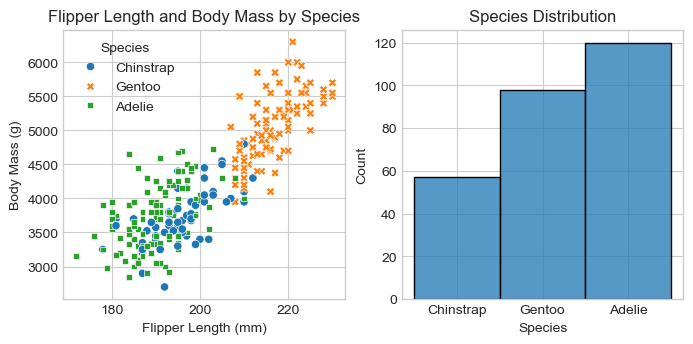

In [143]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

p1 = sns.scatterplot(train, x = "Flipper Length (mm)", y = "Body Mass (g)", hue = "Species", style = "Species", ax = ax[0]).set_title("Flipper Length and Body Mass by Species")
p2 = sns.histplot(train, x = "Species", ax = ax[1]).set_title("Species Distribution")

These two graphics help to visualize potential relationships present in the data. We do not see a clear separation of the species groups while viewing Body Mass and Flipper Length. This indicates that these variables may not be the best choice for our model. The histogram of the species uncovers the distribution of the different species in the dataset. There are more Adelia samples in the training data than any other species. From this distribution, we learn that we must pay attention to the accuracy of the model according to the error rates across classes to ensure model efficiency. 

From the exploratory analysis above, we can move forward to the model selection process. Below contains methodology to train and score Logistic Regression and Support Vector Machines models via cross-validation with most combinations of quantitative and qualitative predictor variables.

## Model and Feature Selection

In [144]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

all_qual_cols = X_train.select_dtypes(include='bool')
all_quant_cols = X_train.select_dtypes(include=np.number)
best_LR_score = 0
best_SVM_score = 0
best_LR_cols = []
best_SVM_cols = []

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 

    LR = LogisticRegression()
    LR.fit(X_train[cols], y_train)
    SVM = SVC()
    SVM.fit(X_train[cols], y_train)
    
    LR_score = cross_val_score(LR, X_train[cols], y_train, cv = 5).mean()
    SVM_score = cross_val_score(SVM, X_train[cols], y_train, cv = 5).mean()
    
    if LR_score > best_LR_score:
      best_LR_cols = cols
      best_LR_score = LR_score
    if SVM_score > best_SVM_score:
      best_SVM_cols = cols
      best_SVM_score = SVM_score

In [145]:
print("Best LR Score: ", best_LR_score,
      "\n Best SVM Score: ", best_SVM_score)

Best LR Score:  0.9922322775263952 
 Best SVM Score:  0.890573152337858


In [146]:
print("Best LR Columns: ", best_LR_cols)

Best LR Columns:  ['Island_Dream', 'Culmen Length (mm)', 'Culmen Depth (mm)']


From this model selection process, we can conclude that the logistic regression model process is favorable for this prediction task as it boasts a mean accuracy over 5 cross-validation folds of $0.9922$. We will move forward with the best columns associated with the greater accuracy of the logistic regression model, being 'Island', 'Culmen Length', 'Culmen Depth'. We will use all three variables derived from island association.

In [147]:
selected_cols = ["Culmen Length (mm)", 
                 "Culmen Depth (mm)",
                 "Island_Dream", 
                 "Island_Biscoe",
                 "Island_Torgersen"]

LR = LogisticRegression()
LR.fit(X_train[selected_cols], y_train)
scores = cross_val_score(LR, X_train[selected_cols], y_train, cv = 5)
scores

array([0.981, 1.   , 1.   , 1.   , 1.   ])

Using all selected features, including island association variables, the Logistic Regression model nearly boasts perfect accuracy on the training data sample. Let's see how it performs on the testing data.

In [148]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"] = test["Species"].str.split().str.get(0)

X_test, y_test = prepare_data(test)
LR.score(X_test[selected_cols], y_test)

1.0

Wow! A perfect score! Exquisite modeling! Let's visualize our model findings. 

## Final Model Visualizations

In [149]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

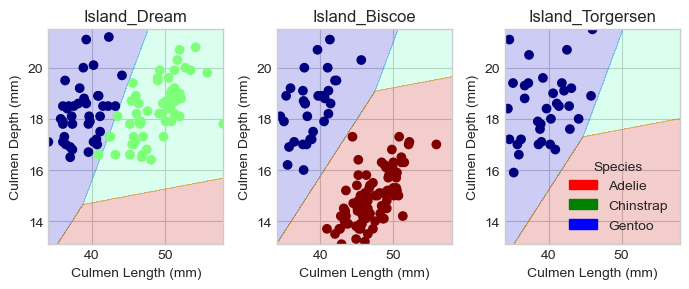

In [150]:
plot_regions(LR, X_train[selected_cols], y_train)

The plot_regions() function provided to us allows us to visualize the model's decisions based on the selected features. The view is faceted by the dummy variables previously created for the Island column. These visualizations of the data help to inform us how the data are being split in the Logistic Regression model. On Dream and Biscoe Island, different species live on both, thus making the classification job more difficult. This is accounted for using the measurements for the culmen length and depth, which help to separate the data as visualized in the plots above. Torgersen Island only house Gentoo penguins, and thus the culmen length and depth measurements are unneccesary to split the data further.

## Confusion Matrix

In [151]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test[selected_cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

This confusion matrix allows us to view in which accuracy categories our model excels and which it underperforms. Fortunately, the model and feature selection processes result in perfect accuracy, in which the model does not make any wrong species predictions for the test data.

# Discussion

This modeling process resulted in finding the favorable prediction model and corresponding features for penguin species prediction in the Palmer's Penguin's dataset. From this exercise we have learned that the most important predictors for species are Island Association, Culmen Length, and Culmen Depth. It is intriguing how, across species, the culmen's vary enough in length and depth to very accurately make a prediction. Based on the initial data exploration, I would have guessed that Body Mass would have been a more significant predictor, as we see great differences across groups. This goes to show that the numbers may not always be as they appear initially.